In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from lib.data import generate_top_n_for_all_users, get_ratings, get_predictions, get_top_n, get_relevant_items_for_user, set_items, get_users, set_ratings, set_predictions, get_cold_users, get_ratings_distribution

# Metric Imports
from lib.availability import availability_for_user
from lib.coverage import is_user_covered, category_coverage_for_user
from lib.diversity import intralist_price_diversity_for_user, intralist_category_diversity_for_user
from lib.mrr import mrr_for_user
from lib.precision import average_precision_for_user
from lib.rmse import rmse_for_user
from lib.serendipity import serendipity_for_user
from lib.ndcg import ndcg

from lib.utils import read_items_from_file, read_ratings_from_file, read_predictions_from_file, calculate_statistics, generate_output_files

In [2]:
ALGORITHMS = ['cbf', 'item-item', 'mf', 'perbias', 'user-user']

SINGLEVALUE_METRICS = ['Coverage.Item', 'Coverage.User']
MULTIVALUE_METRICS = ['Availability', 'MRR', 'Serendipity',
                    'MAP', 'RMSE.Predict', 'RMSE.TopN', 'nDCG', 'Diversity.Price', 'Diversity.Category']

ratings = read_ratings_from_file()
set_ratings(ratings, 10)
ITEMS = read_items_from_file()
set_items(ITEMS)
ALL_CATEGORIES = set(map(lambda x: x['Category'], ITEMS))

In [3]:
results = {}

for metric in (SINGLEVALUE_METRICS + MULTIVALUE_METRICS):
  results[metric] = {}

for algorithm in ALGORITHMS:
  predictions = read_predictions_from_file(algorithm)
  set_predictions(predictions)

  users = get_cold_users()
  generate_top_n_for_all_users(users)

  items_recommended = set()
  users_covered = 0.0

  availability_values = []
  mrr_values = []
  serendipity_values = []
  map_values = []
  rmse_predict_values = []
  rmse_top_values = []
  ndcg_values = []
  diversity_price_values = []
  diversity_category_values = []

  for user_id in users:
    top_n = get_top_n(user_id, 5)
    user_ratings = get_ratings(user_id)
    user_relevant_items = get_relevant_items_for_user(user_id)
    user_predictions = get_predictions(user_id)

    # Coverage Metrics
    items_recommended = items_recommended | set(top_n['Item'])

    if is_user_covered(top_n):
      users_covered += 1.0

    # Other metrics
    availability_values.append(availability_for_user(top_n))
    mrr_values.append(mrr_for_user(top_n, user_relevant_items))
    serendipity_values.append(serendipity_for_user(top_n, user_id))
    map_values.append(average_precision_for_user(top_n, user_id))
    
    rmse_predict = rmse_for_user(user_id, user_ratings, user_predictions)
    rmse_predict_values.append(rmse_predict)
        
        
    rmse_top_n = rmse_for_user(user_id, user_ratings, top_n)
    rmse_top_values.append(rmse_top_n)
        
        
    ndcg_values.append(ndcg(user_id, top_n))
    diversity_price_values.append(intralist_price_diversity_for_user(top_n))
    diversity_category_values.append(intralist_category_diversity_for_user(top_n))

  results['Availability'][algorithm] = calculate_statistics(availability_values, algorithm)
  results['MRR'][algorithm] = calculate_statistics(mrr_values, algorithm)
  results['Serendipity'][algorithm] = calculate_statistics(serendipity_values, algorithm)
  results['MAP'][algorithm] = calculate_statistics(map_values, algorithm)
  results['RMSE.Predict'][algorithm] = calculate_statistics(rmse_predict_values, algorithm)
  results['RMSE.TopN'][algorithm] = calculate_statistics(rmse_top_values, algorithm)
  results['nDCG'][algorithm] = calculate_statistics(ndcg_values, algorithm)
  results['Diversity.Price'][algorithm] = calculate_statistics(diversity_price_values, algorithm)
  results['Diversity.Category'][algorithm] = calculate_statistics(diversity_category_values, algorithm)

  results['Coverage.Item'][algorithm] = [float(len(items_recommended))/float(len(ITEMS))]
  results['Coverage.User'][algorithm] = [users_covered/float(len(users))]

results['Availability'] = pd.concat([results['Availability'][algorithm] for algorithm in ALGORITHMS])
results['MRR'] = pd.concat([results['MRR'][algorithm] for algorithm in ALGORITHMS])
results['Serendipity'] = pd.concat([results['Serendipity'][algorithm] for algorithm in ALGORITHMS])
results['MAP'] = pd.concat([results['MAP'][algorithm] for algorithm in ALGORITHMS])
results['RMSE.Predict'] = pd.concat([results['RMSE.Predict'][algorithm] for algorithm in ALGORITHMS])
results['RMSE.TopN'] = pd.concat([results['RMSE.TopN'][algorithm] for algorithm in ALGORITHMS])
results['nDCG'] = pd.concat([results['nDCG'][algorithm] for algorithm in ALGORITHMS])
results['Diversity.Price'] = pd.concat([results['Diversity.Price'][algorithm] for algorithm in ALGORITHMS])
results['Diversity.Category'] = pd.concat([results['Diversity.Category'][algorithm] for algorithm in ALGORITHMS])

     Item        65
187  2257  5.112144
46   1032  5.070094
140  1874  5.031666
20    327  4.998372
184  2247  4.997032
30    619  4.991644
85   1387  4.989558
62   1292  4.989048
169  2169  4.981601
0      24  4.970097
4      45  4.966481
5      71  4.966232
3      41  4.960017
1      30  4.953063
66   1297  4.942263
142  1890  4.941388
83   1377  4.940908
67   1298  4.940018
25    454  4.934040
134  1809  4.930486
125  1796  4.926801
26    482  4.916647
149  1951  4.913603
49   1118  4.910685
110  1627  4.895426
10    133  4.884557
59   1245  4.883428
13    191  4.871583
12    189  4.870622
121  1763  4.867268
..    ...       ...
194  2319  4.277629
8     124  4.274998
195  2321  4.255061
18    298  4.226013
36    806  4.202495
137  1828  4.200661
90   1451  4.197908
178  2230  4.176248
114  1659  4.166954
136  1822  4.163119
196  2324  4.160742
192  2316  4.157808
39    829  4.155735
180  2233  4.123796
117  1700  4.113625
145  1937  4.105970
176  2224  4.095424
94   1456  4.057117


     Item        65
187  2257  5.175874
140  1874  5.044270
46   1032  5.016726
142  1890  4.972981
34    779  4.900627
73   1323  4.890412
59   1245  4.878226
0      24  4.876618
95   1461  4.864242
49   1118  4.852752
3      41  4.846841
25    454  4.843963
20    327  4.840850
164  2099  4.834237
138  1830  4.828911
4      45  4.824686
135  1820  4.793264
106  1524  4.787444
199  2394  4.787080
125  1796  4.773340
144  1896  4.772307
84   1379  4.769829
83   1377  4.769339
65   1296  4.743016
111  1633  4.734752
66   1297  4.734723
12    189  4.725084
62   1292  4.716900
28    540  4.710965
122  1764  4.705157
..    ...       ...
177  2227  4.037503
178  2230  4.033422
91   1453  4.019285
136  1822  4.010501
196  2324  3.999757
176  2224  3.998355
127  1799  3.977607
114  1659  3.961374
147  1943  3.953017
148  1945  3.938276
116  1680  3.935132
94   1456  3.934563
103  1510  3.916660
146  1938  3.876122
195  2321  3.862893
117  1700  3.855764
192  2316  3.834419
90   1451  3.795311


     Item        65
187  2257  5.017640
30    619  5.009821
20    327  4.984165
140  1874  4.963254
169  2169  4.941842
46   1032  4.941288
5      71  4.920253
62   1292  4.915515
3      41  4.911528
85   1387  4.905795
66   1297  4.904599
4      45  4.900232
67   1298  4.898687
0      24  4.886359
95   1461  4.884568
83   1377  4.878889
134  1809  4.878183
25    454  4.873140
125  1796  4.867947
184  2247  4.862633
10    133  4.860685
49   1118  4.855376
149  1951  4.850847
55   1240  4.844305
110  1627  4.843553
1      30  4.841951
13    191  4.825825
34    779  4.824632
26    482  4.823932
28    540  4.822456
..    ...       ...
147  1943  4.259719
124  1793  4.257317
196  2324  4.250431
115  1666  4.235942
178  2230  4.221900
137  1828  4.197513
136  1822  4.183110
180  2233  4.158182
18    298  4.156038
90   1451  4.141991
39    829  4.140528
36    806  4.139685
192  2316  4.130337
117  1700  4.119702
176  2224  4.107920
114  1659  4.092407
145  1937  4.076220
94   1456  4.044999


     Item        65
187  2257  5.098354
20    327  5.038582
140  1874  5.037919
46   1032  5.026128
85   1387  4.993779
62   1292  4.986951
184  2247  4.982668
169  2169  4.977195
5      71  4.951295
66   1297  4.948144
67   1298  4.946001
3      41  4.944573
1      30  4.936589
0      24  4.934751
134  1809  4.932668
4      45  4.932419
149  1951  4.932217
25    454  4.931233
30    619  4.930287
83   1377  4.927112
125  1796  4.919126
26    482  4.900212
49   1118  4.896557
110  1627  4.882668
10    133  4.882668
12    189  4.868175
59   1245  4.868175
13    191  4.861163
126  1798  4.858203
28    540  4.854555
..    ...       ...
124  1793  4.300747
56   1241  4.285446
18    298  4.260119
115  1666  4.243028
196  2324  4.216001
36    806  4.203731
178  2230  4.196001
90   1451  4.194023
136  1822  4.182103
137  1828  4.180707
192  2316  4.153501
39    829  4.150427
114  1659  4.145579
180  2233  4.142317
176  2224  4.123694
117  1700  4.094789
145  1937  4.093779
94   1456  4.035278


     Item        65
4      45  5.367683
121  1763  5.243394
30    619  5.238863
160  2068  5.184786
95   1461  5.177583
15    256  5.153468
83   1377  5.126769
84   1379  5.122441
149  1951  5.074859
165  2100  5.072313
126  1798  5.059499
7     103  5.049506
93   1455  5.048498
104  1518  5.045834
94   1456  5.034205
25    454  5.033398
62   1292  5.027434
70   1317  5.022963
66   1297  5.011960
37    817  5.009515
110  1627  5.009184
59   1245  5.002533
3      41  5.001494
9     129  4.996322
135  1820  4.990216
129  1801  4.987509
68   1299  4.985373
127  1799  4.983228
85   1387  4.973713
53   1217  4.971599
..    ...       ...
189  2279  4.508569
194  2319  4.501839
180  2233  4.498032
184  2247  4.496578
188  2258  4.482546
154  2040  4.452526
195  2321  4.449117
109  1573  4.448766
75   1326  4.443185
13    191  4.435590
36    806  4.424856
24    435  4.414436
191  2309  4.404589
157  2045  4.382926
43    952  4.347945
196  2324  4.308682
183  2242  4.307927
23    423  4.299904


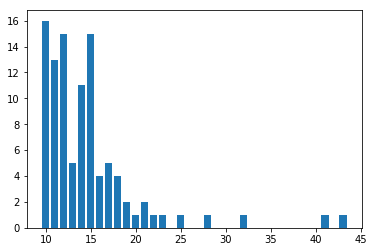

In [4]:
distribution = get_ratings_distribution()

plt.bar(distribution.keys(), distribution.values())
plt.show()


In [5]:
df = pd.DataFrame.from_dict([distribution])
df = df.rename(index={0: 'Users Count'})
df

,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,28,32,41,43
Users Count,16,13,15,5,11,15,4,5,4,2,1,2,1,1,1,1,1,1,1


In [6]:
colors= ['g', 'b', 'r', 'y', 'purple']
labels = ['Content Based Filtering', 'Item-Item CF', 'Matrix Factorization', 'Personalized Bias', 'User-User CB']

width = 10 # inch
aspect = 0.8 # height/width ratio
height = width*aspect
plt.rcParams['figure.figsize'] = [width, height]

n_groups = 1
index = np.arange(n_groups)
bar_width = 0.35

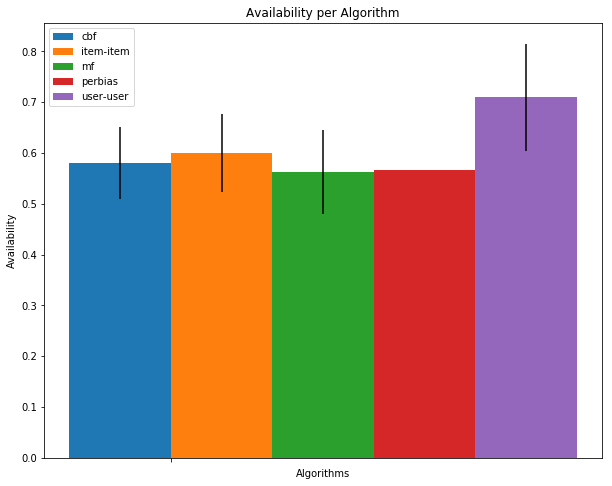

In [7]:
metric = results['Availability']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Availability')
ax.set_title('Availability per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [8]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.510899,0.531664,0.566868,0.604401,0.780201,0.802512,0.580693,0.508016,0.071108
item-item,0.534962,0.542552,0.599897,0.634643,0.790161,0.807144,0.599560,0.462140,0.077003
mf,0.468187,0.490999,0.531498,0.637614,0.684572,0.684572,0.561798,0.468187,0.082886
perbias,0.566868,0.566868,0.566868,0.566868,0.566868,0.566868,0.566868,0.566868,0.000000
user-user,0.571730,0.644749,0.718888,0.763165,0.912630,0.918805,0.709562,0.515841,0.105426


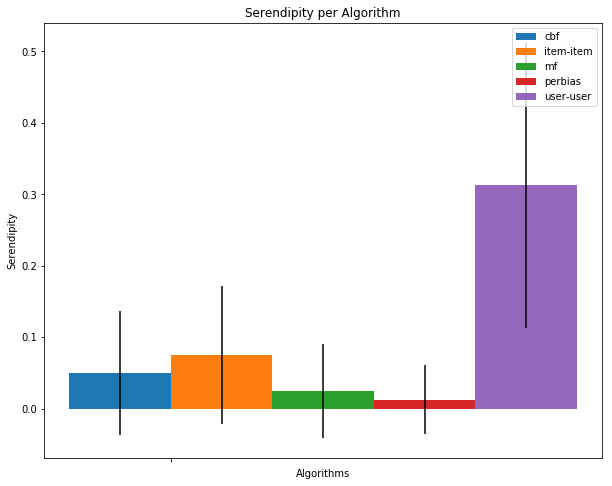

In [9]:
metric = results['Serendipity']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Serendipity')
ax.set_title('Serendipity per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [10]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.0,0.0,0.0,0.05,0.20,0.2,0.0500,0.0,0.086603
item-item,0.0,0.0,0.0,0.20,0.20,0.2,0.0750,0.0,0.096825
mf,0.0,0.0,0.0,0.00,0.20,0.2,0.0250,0.0,0.066144
perbias,0.0,0.0,0.0,0.00,0.17,0.2,0.0125,0.0,0.048412
user-user,0.1,0.2,0.2,0.45,0.60,0.6,0.3125,0.0,0.199609


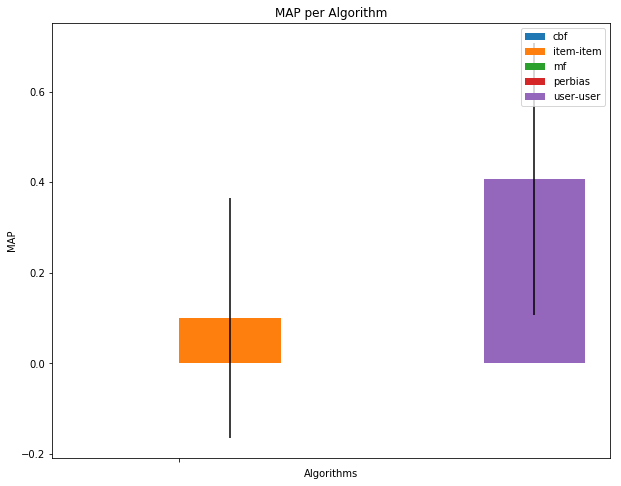

In [11]:
metric = results['MAP']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('MAP')
ax.set_title('MAP per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [12]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.0,0.0,0.000000,0.000,0.0,0.0,0.000000,0.0,0.000000
item-item,0.0,0.0,0.000000,0.000,0.8,0.8,0.100000,0.0,0.264575
mf,0.0,0.0,0.000000,0.000,0.0,0.0,0.000000,0.0,0.000000
perbias,0.0,0.0,0.000000,0.000,0.0,0.0,0.000000,0.0,0.000000
user-user,0.0,0.0,0.483333,0.625,0.8,0.8,0.407292,0.0,0.300519


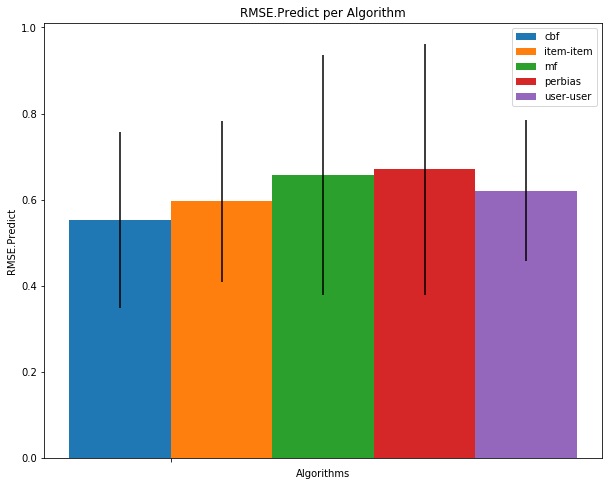

In [13]:
metric = results['RMSE.Predict']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('RMSE.Predict')
ax.set_title('RMSE.Predict per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [14]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.335850,0.406852,0.480029,0.689760,0.996271,1.017527,0.552030,0.266683,0.205055
item-item,0.374872,0.452340,0.546364,0.717814,0.976962,0.991441,0.595775,0.359087,0.187695
mf,0.381236,0.456333,0.530124,0.839276,1.229491,1.258139,0.656679,0.311749,0.279411
perbias,0.388938,0.459293,0.542350,0.841719,1.339938,1.389332,0.670105,0.344744,0.292320
user-user,0.455000,0.543192,0.598944,0.674195,0.997065,1.027937,0.620934,0.320745,0.164500


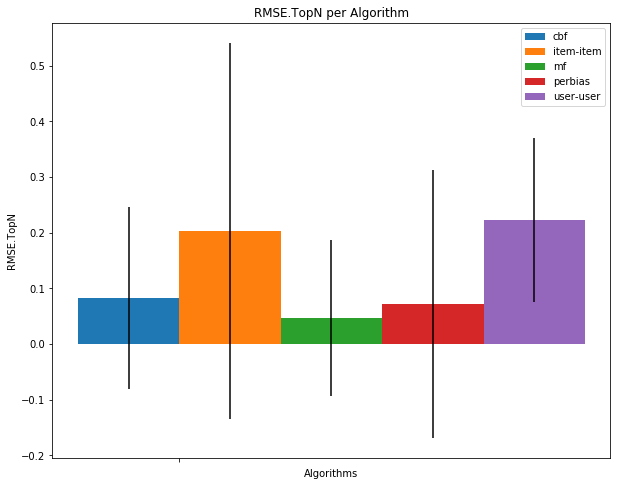

In [15]:
metric = results['RMSE.TopN']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('RMSE.TopN')
ax.set_title('RMSE.TopN per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [16]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.00000,0.000000,0.000000,0.025341,0.496510,0.505713,0.082809,0.0,0.163662
item-item,0.00000,0.000000,0.000000,0.280044,1.104627,1.143694,0.203369,0.0,0.338037
mf,0.00000,0.000000,0.000000,0.000000,0.502663,0.558041,0.046681,0.0,0.139689
perbias,0.00000,0.000000,0.000000,0.000000,0.868946,0.993779,0.072208,0.0,0.241127
user-user,0.03527,0.122713,0.208147,0.331367,0.505924,0.524713,0.222774,0.0,0.147021


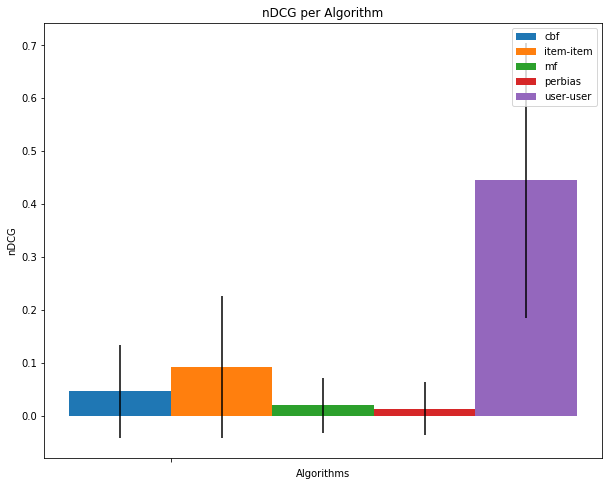

In [17]:
metric = results['nDCG']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('nDCG')
ax.set_title('nDCG per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [18]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.000000,0.000000,0.000000,0.031007,0.289048,0.310737,0.045875,0.0,0.087886
item-item,0.000000,0.000000,0.000000,0.177535,0.408087,0.416739,0.091912,0.0,0.134313
mf,0.000000,0.000000,0.000000,0.000000,0.161297,0.163175,0.019614,0.0,0.051942
perbias,0.000000,0.000000,0.000000,0.000000,0.176011,0.207072,0.012942,0.0,0.050124
user-user,0.057723,0.279984,0.478833,0.711700,0.772299,0.779837,0.444785,0.0,0.260098


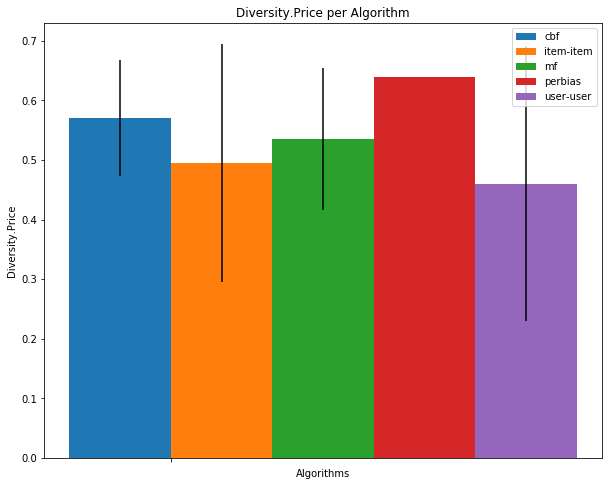

In [19]:
metric = results['Diversity.Price']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Diversity.Price')
ax.set_title('Diversity.Price per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [20]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.44,0.54,0.64,0.64,0.64,0.64,0.570,0.32,0.097468
item-item,0.24,0.38,0.56,0.64,0.72,0.72,0.495,0.00,0.200437
mf,0.40,0.40,0.64,0.64,0.64,0.64,0.535,0.40,0.119059
perbias,0.64,0.64,0.64,0.64,0.64,0.64,0.640,0.64,0.000000
user-user,0.12,0.30,0.56,0.64,0.72,0.72,0.460,0.00,0.230651


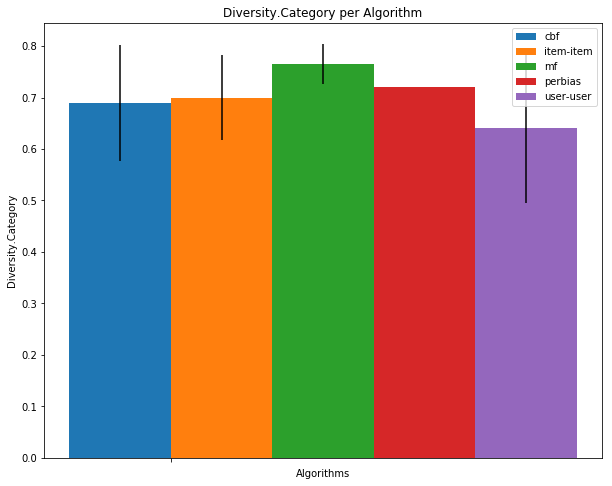

In [21]:
metric = results['Diversity.Category']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Diversity.Category')
ax.set_title('Diversity.Category per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [22]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.60,0.70,0.72,0.72,0.80,0.80,0.690,0.32,0.112694
item-item,0.56,0.64,0.72,0.74,0.80,0.80,0.700,0.56,0.082462
mf,0.72,0.72,0.80,0.80,0.80,0.80,0.765,0.72,0.039686
perbias,0.72,0.72,0.72,0.72,0.72,0.72,0.720,0.72,0.000000
user-user,0.44,0.56,0.72,0.72,0.80,0.80,0.640,0.32,0.144222
